In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from math import sqrt
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from ipywidgets import widgets

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

# ignore future warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
train_df = pd.read_csv("train.csv")
train_df.replace("NaN",np.nan,regex=True,inplace=True)
test_df = pd.read_csv("test.csv")
test_df.replace("NaN",np.nan,regex=True,inplace=True)

cols = ['ID', 'Delivery_person_ID', 'City', 'Delivery_person_Age', 'Type_of_order', 'Festival']

train_df.drop(columns=cols, axis=1, inplace=True)
test_df.drop(columns=cols, axis=1, inplace=True)

train_df.sample(10)

,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Time_taken(min)
44729,4.6,12.933298,77.614293,12.963298,77.644293,05-03-2022,18:20:00,18:30:00,conditions Windy,Medium,2,scooter,1,(min) 33
26517,4.8,12.323994,76.626167,12.353994,76.656167,26-03-2022,23:10:00,23:20:00,conditions Fog,Low,1,motorcycle,1,(min) 16
28128,5,22.725748,75.898497,22.775748,75.948497,21-03-2022,21:15:00,21:30:00,conditions Cloudy,Jam,1,motorcycle,1,(min) 33
31625,4.8,26.849596,75.800512,26.909596,75.860512,24-03-2022,19:00:00,19:05:00,conditions Fog,Medium,0,motorcycle,1,(min) 20
19499,NaN,22.722634,75.886959,22.762634,75.926959,13-03-2022,NaN,12:25:00,conditions Windy,High,1,scooter,0,(min) 24
16491,4.1,11.022477,76.995667,11.132477,77.105667,25-03-2022,17:25:00,17:35:00,conditions Stormy,Medium,2,scooter,1,(min) 39
39841,4.4,19.109300,72.825451,19.139300,72.855451,21-03-2022,23:15:00,23:20:00,conditions Sandstorms,Low,0,motorcycle,1,(min) 29
11210,4.7,13.026286,80.275235,13.086286,80.335235,21-03-2022,23:40:00,23:55:00,conditions Cloudy,Low,1,scooter,0,(min) 15
42524,4.6,22.745536,75.893106,22.835536,75.983106,16-03-2022,19:45:00,19:50:00,conditions Fog,Jam,2,scooter,1,(min) 44
42240,4.8,18.533811,73.899315,18.613811,73.979315,04-03-2022,23:50:00,00:05:00,conditions Sandstorms,Low,1,scooter,1,(min) 20


In [3]:
train_df.isna().sum()

Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions               616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_vehicle                   0
multiple_deliveries             993
Time_taken(min)                   0
dtype: int64

In [4]:
train_df.drop(["Order_Date"],axis=1,inplace=True)
test_df.drop(["Order_Date"],axis=1,inplace=True)

train_df["Time_taken(min)"] = train_df["Time_taken(min)"].apply(lambda x:x.replace("(min) ",""))
train_df["Time_taken(min)"] = train_df["Time_taken(min)"].astype("int")

In [5]:
train_df["Time_Order_picked"] = pd.to_timedelta(train_df["Time_Order_picked"])
test_df["Time_Order_picked"] = pd.to_timedelta(test_df["Time_Order_picked"])

In [6]:
train_time_nan = train_df[train_df["Time_Orderd"].isna()]

for index in (train_time_nan.index):
    train_df.loc[index,["Time_Orderd"]] = train_df.loc[index,"Time_Order_picked"] - pd.to_timedelta(train_df.loc[index,"Time_taken(min)"],unit="m")

In [7]:
train_df["Time_Order_picked"] = train_df["Time_Order_picked"].apply(lambda x: x.total_seconds())
test_df["Time_Order_picked"] = test_df["Time_Order_picked"].apply(lambda x: x.total_seconds())

train_df["Time_Orderd"] = pd.to_timedelta(train_df["Time_Orderd"])
train_df["Time_Orderd"] = train_df["Time_Orderd"].apply(lambda x: x.total_seconds())

test_df["Time_Orderd"] = pd.to_timedelta(test_df["Time_Orderd"])
test_df["Time_Orderd"] = test_df["Time_Orderd"].apply(lambda x: x.total_seconds())



In [8]:
train_df.sort_values(by=['Time_Orderd'], ascending=True).head(10)

,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Time_taken(min)
31282,NaN,22.761593,75.886362,22.831593,75.956362,-2280.0,0.0,conditions Sunny,Low,1,motorcycle,1,38
29540,NaN,-12.323225,-76.630028,12.403225,76.710028,-1980.0,600.0,NaN,NaN,3,motorcycle,2,43
42520,NaN,13.045479,80.233110,13.125479,80.313110,-1920.0,600.0,NaN,NaN,3,electric_scooter,2,42
32968,NaN,11.010375,76.952950,11.080375,77.022950,-1740.0,0.0,conditions Sunny,Low,2,scooter,1,29
23469,NaN,-21.157735,72.768778,21.247735,72.858778,-1740.0,900.0,conditions Cloudy,Low,0,motorcycle,1,44
11092,NaN,21.173343,72.792731,21.283343,72.902731,-1740.0,600.0,conditions Cloudy,Low,0,motorcycle,1,39
11457,NaN,17.459710,78.368855,17.529710,78.438855,-1680.0,0.0,conditions Stormy,Low,1,motorcycle,1,28
2532,NaN,26.914142,75.805704,27.044142,75.935704,-1680.0,0.0,NaN,NaN,3,electric_scooter,1,28
23035,1,0.000000,0.000000,0.070000,0.070000,-1620.0,0.0,NaN,NaN,3,scooter,0,27
16840,NaN,22.753659,75.903365,22.843659,75.993365,-1620.0,0.0,conditions Fog,Low,2,scooter,1,27


In [9]:
train_df['multiple_deliveries'].fillna(train_df['multiple_deliveries'].mode()[0], inplace=True)
test_df['multiple_deliveries'].fillna(test_df['multiple_deliveries'].mode()[0], inplace=True)

train_df['multiple_deliveries'] = train_df['multiple_deliveries'].astype("int")
test_df['multiple_deliveries'] = test_df['multiple_deliveries'].astype("int")

train_df["multiple_deliveries"] = train_df["multiple_deliveries"].apply(lambda x: 1 if x >= 1 else 0)
test_df["multiple_deliveries"] = test_df["multiple_deliveries"].apply(lambda x: 1 if x >= 1 else 0)

In [10]:
train_df["Weatherconditions"].fillna(train_df["Weatherconditions"].mode()[0],inplace=True)
test_df["Weatherconditions"].fillna(test_df["Weatherconditions"].mode()[0],inplace=True)

In [11]:
train_df["Road_traffic_density"].fillna(train_df["Road_traffic_density"].mode()[0],inplace=True)
test_df["Road_traffic_density"].fillna(test_df["Road_traffic_density"].mode()[0],inplace=True)

train_df["Road_traffic_density"] = train_df["Road_traffic_density"].replace("Low ",0).replace("Medium ",1).replace("High ",2).replace("Jam ",3)
test_df["Road_traffic_density"] = test_df["Road_traffic_density"].replace("Low ",0).replace("Medium ",1).replace("High ",2).replace("Jam ",3)

In [12]:
train_df['Delivery_person_Ratings'] = train_df['Delivery_person_Ratings'].astype(float)
test_df['Delivery_person_Ratings'] = test_df['Delivery_person_Ratings'].astype(float)

train_df['Delivery_person_Ratings'] = train_df['Delivery_person_Ratings'].fillna(train_df['Delivery_person_Ratings'].mode()[0])
test_df['Delivery_person_Ratings'] = test_df['Delivery_person_Ratings'].fillna(test_df['Delivery_person_Ratings'].mode()[0])

In [13]:
train_df['Restaurant_latitude'] = train_df['Restaurant_latitude'].abs()
train_df['Restaurant_longitude'] = train_df['Restaurant_longitude'].abs()

In [14]:
train_df["Type_of_vehicle"] = train_df["Type_of_vehicle"].str.strip()
test_df["Type_of_vehicle"] = test_df["Type_of_vehicle"].str.strip()

train_df["Type_of_vehicle"] = train_df["Type_of_vehicle"].replace("motorcycle",0).replace("scooter",1).replace("electric_scooter",2).replace("bicycle",3)
test_df["Type_of_vehicle"] = test_df["Type_of_vehicle"].replace("motorcycle",0).replace("scooter",1).replace("electric_scooter",2).replace("bicycle",3)

In [15]:
train_df["Weatherconditions"] = train_df["Weatherconditions"].apply(lambda x:x.replace("conditions ",""))
test_df["Weatherconditions"] = test_df["Weatherconditions"].apply(lambda x:x.replace("conditions ",""))

train_df["Weatherconditions"] = train_df["Weatherconditions"].replace("Sunny",0).replace("Cloudy",1).replace("Windy",2).replace("Fog",3).replace("Stormy",4).replace("Sandstorms",5)
test_df["Weatherconditions"] = test_df["Weatherconditions"].replace("Sunny",0).replace("Cloudy",1).replace("Windy",2).replace("Fog",3).replace("Stormy",4).replace("Sandstorms",5)

In [16]:
train_df.sample(5)

,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Time_taken(min)
14061,4.8,26.902940,75.793007,26.942940,75.833007,46500.0,46800.0,5,2,2,0,1,27
9277,4.8,13.054347,80.257221,13.084347,80.287221,83640.0,84300.0,5,0,1,1,1,11
32138,3.9,11.003669,76.976494,11.133669,77.106494,74400.0,74700.0,4,3,2,1,0,35
42308,4.7,19.223840,72.841347,19.313840,72.931347,77100.0,78000.0,0,3,1,1,1,25
13786,4.4,12.939496,77.625999,13.009496,77.695999,81600.0,81900.0,1,0,0,0,1,40


In [17]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Delivery_person_Ratings,45593.0,4.640737,0.329324,1.00,4.600000,4.700000,4.800000,6.000000
Restaurant_latitude,45593.0,17.401571,7.333766,0.00,12.934179,18.554382,22.732225,30.914057
Restaurant_longitude,45593.0,70.782088,21.118611,0.00,73.170283,75.898497,78.046106,88.433452
Delivery_location_latitude,45593.0,17.465186,7.335122,0.01,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45593.0,70.845702,21.118812,0.01,73.280000,76.002574,78.107044,88.563452
Time_Orderd,45593.0,64375.605904,17537.202024,-2280.00,55200.000000,69300.000000,77700.000000,86100.000000
Time_Order_picked,45593.0,63437.389512,19317.706871,0.00,52500.000000,69000.000000,77700.000000,86100.000000
Weatherconditions,45593.0,2.522514,1.690505,0.00,1.000000,3.000000,4.000000,5.000000
Road_traffic_density,45593.0,1.364815,1.247976,0.00,0.000000,1.000000,3.000000,3.000000
Vehicle_condition,45593.0,1.023359,0.839065,0.00,0.000000,1.000000,2.000000,3.000000


<Figure size 1200x600 with 0 Axes>

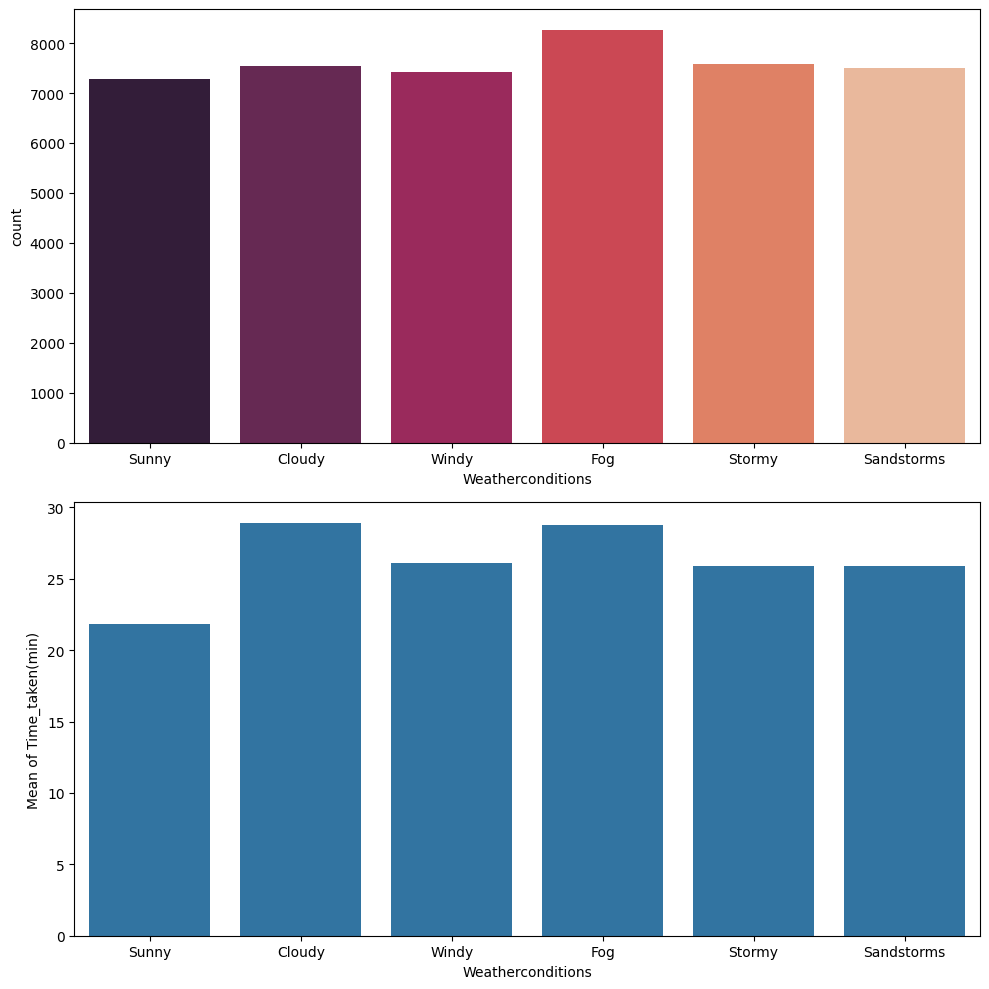

In [18]:
Weatherconditionsdf = train_df.groupby("Weatherconditions")["Time_taken(min)"].mean().to_frame().reset_index()
plt.figure(figsize=(12,6))
fig , ax = plt.subplots(2,1,figsize = (10,10))
ax1=sns.barplot(x=Weatherconditionsdf["Weatherconditions"],y=Weatherconditionsdf["Time_taken(min)"],ax=ax[1])
ax1.set_ylabel("Mean of Time_taken(min)")
ax1.set_xticklabels(["Sunny","Cloudy","Windy","Fog","Stormy","Sandstorms"])

ax2 = sns.countplot(x=train_df["Weatherconditions"],palette="rocket",ax=ax[0])
ax2.set_xticklabels(["Sunny","Cloudy","Windy","Fog","Stormy","Sandstorms"])
plt.tight_layout()

<Figure size 1200x600 with 0 Axes>

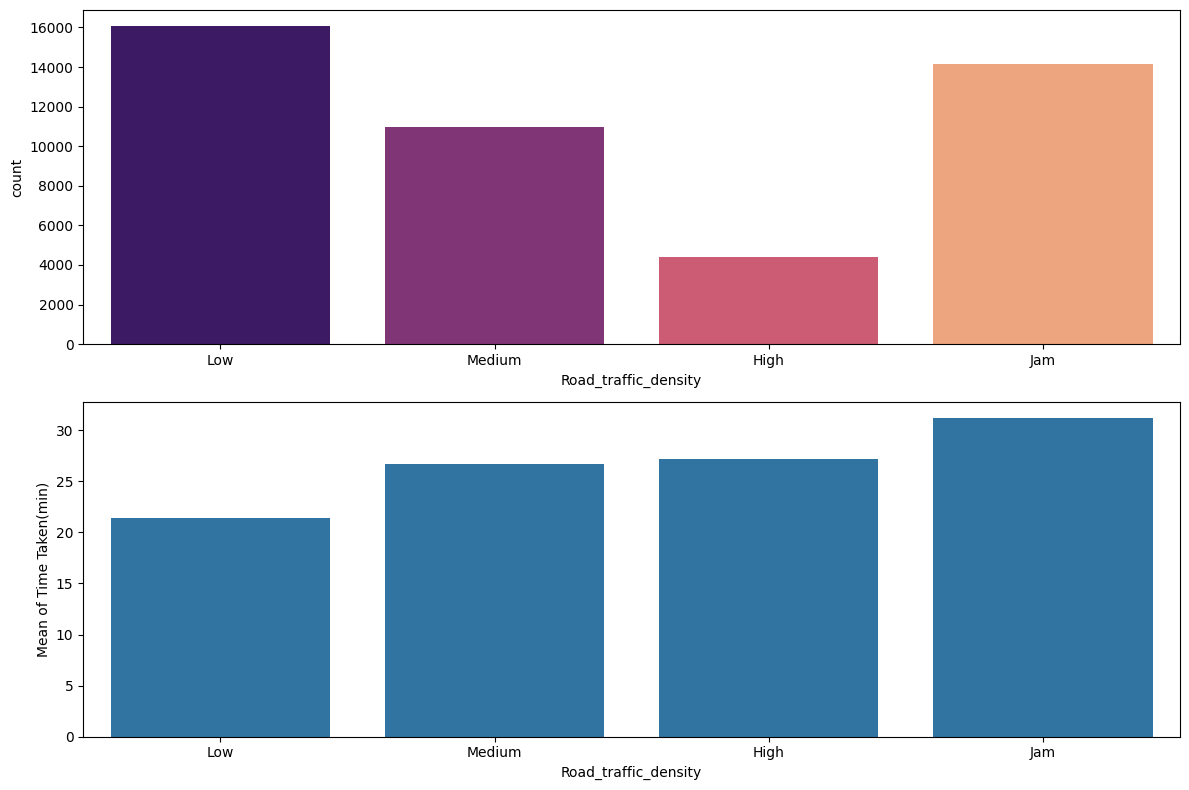

In [19]:
Road_traffic_densitydf = train_df.groupby("Road_traffic_density")["Time_taken(min)"].mean().to_frame().reset_index()
plt.figure(figsize=(12,6))
fig , ax = plt.subplots(2,1,figsize = (12,8))
ax1=sns.barplot(x=Road_traffic_densitydf["Road_traffic_density"],y=Road_traffic_densitydf["Time_taken(min)"],ax=ax[1])
ax1.set_ylabel("Mean of Time Taken(min)")
ax1.set_xticklabels(["Low", "Medium", "High", "Jam"])

ax2 = sns.countplot(x=train_df["Road_traffic_density"],palette="magma",ax=ax[0])
ax2.set_xticklabels(["Low", "Medium", "High", "Jam"])
plt.tight_layout()

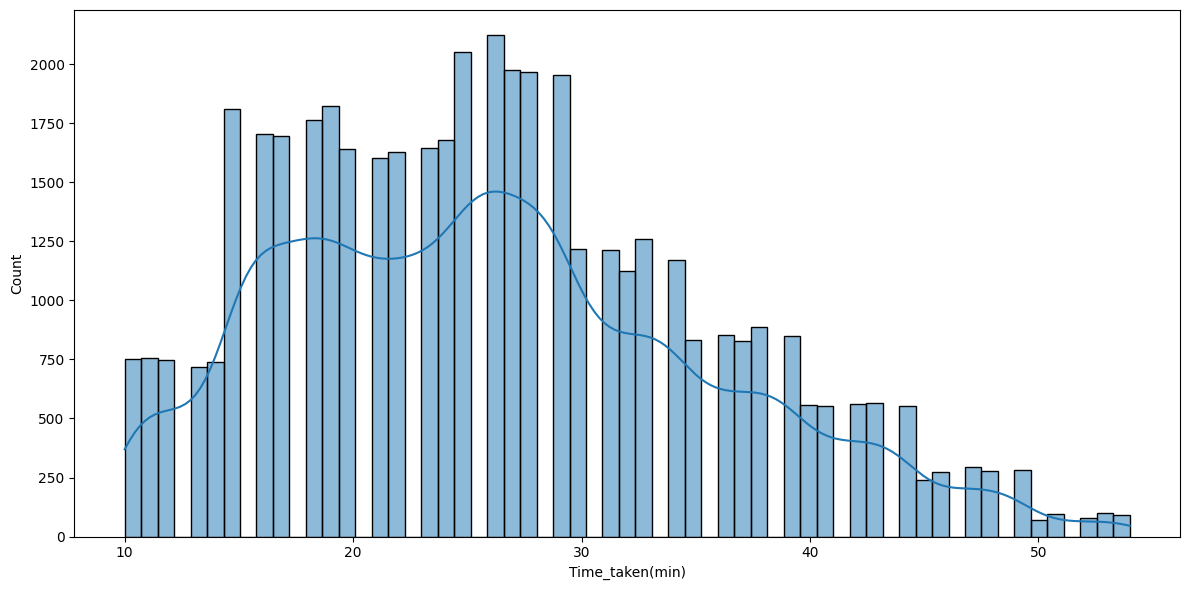

In [20]:
plt.figure(figsize=(12,6))
sns.histplot(x=train_df["Time_taken(min)"], kde=True)
plt.tight_layout()

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Delivery_person_Ratings      45593 non-null  float64
 1   Restaurant_latitude          45593 non-null  float64
 2   Restaurant_longitude         45593 non-null  float64
 3   Delivery_location_latitude   45593 non-null  float64
 4   Delivery_location_longitude  45593 non-null  float64
 5   Time_Orderd                  45593 non-null  float64
 6   Time_Order_picked            45593 non-null  float64
 7   Weatherconditions            45593 non-null  int64  
 8   Road_traffic_density         45593 non-null  int64  
 9   Vehicle_condition            45593 non-null  int64  
 10  Type_of_vehicle              45593 non-null  int64  
 11  multiple_deliveries          45593 non-null  int64  
 12  Time_taken(min)              45593 non-null  int32  
dtypes: float64(7), i

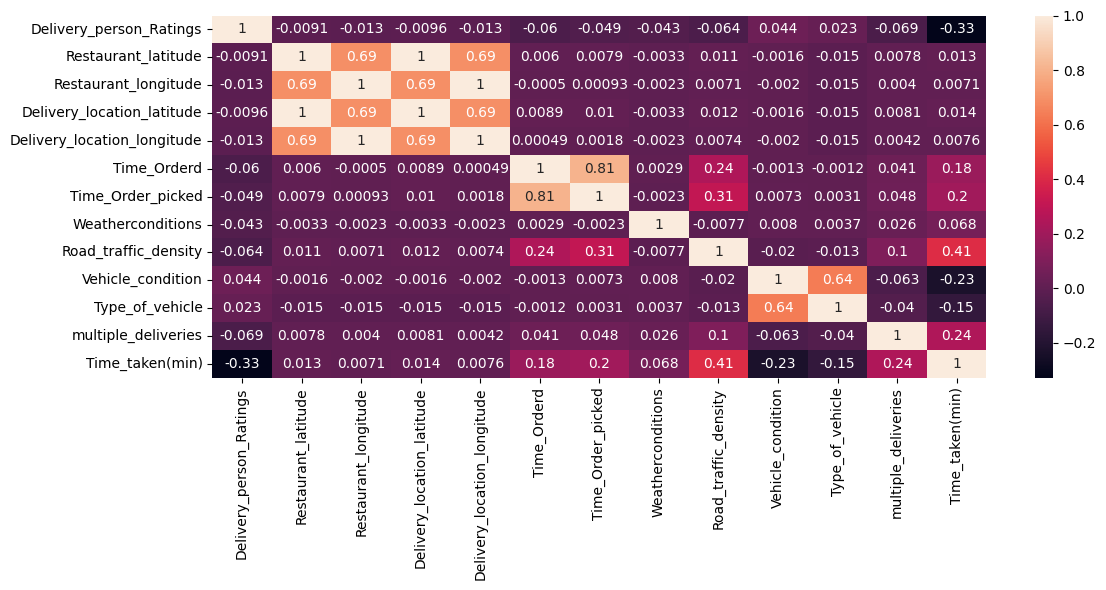

In [22]:
plt.figure(figsize=(12,6))
sns.heatmap(train_df.corr(numeric_only=True),annot=True)
plt.tight_layout()

In [23]:
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


train_df['dist'] = \
    haversine(train_df['Restaurant_latitude'], train_df['Restaurant_longitude'],
              train_df['Delivery_location_latitude'], train_df['Delivery_location_longitude'])
test_df['dist'] = \
    haversine(test_df['Restaurant_latitude'], test_df['Restaurant_longitude'],
              test_df['Delivery_location_latitude'], test_df['Delivery_location_longitude'])

In [24]:
train_df.sort_values(by=['dist'], ascending=True).head()

,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Time_taken(min),dist
26585,4.5,30.914057,75.839820,30.924057,75.849820,33000.0,33600.0,2,0,2,2,1,13,1.465067
7410,4.8,30.914057,75.839820,30.924057,75.849820,40500.0,40800.0,4,2,2,1,1,16,1.465067
33066,4.9,30.914057,75.839820,30.924057,75.849820,39000.0,39900.0,1,0,0,0,1,16,1.465067
28262,4.8,30.905562,75.832841,30.915562,75.842841,42000.0,42300.0,5,2,2,2,1,26,1.465123
18399,4.7,30.905562,75.832841,30.915562,75.842841,31500.0,31800.0,0,0,2,1,1,21,1.465123


In [25]:
train_df.sort_values(by=['dist'], ascending=False).head()

,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Time_taken(min),dist
15710,5.0,25.443994,81.860187,25.583994,82.000187,79800.0,80100.0,5,0,1,0,0,12,20.969489
25926,3.8,25.443994,81.860187,25.583994,82.000187,73500.0,73800.0,5,3,2,0,1,33,20.969489
912,4.7,25.443994,81.860187,25.583994,82.000187,82500.0,83400.0,1,0,2,2,0,26,20.969489
16640,4.8,25.449659,81.839744,25.589659,81.979744,79200.0,80100.0,0,3,1,1,0,20,20.969045
25476,4.7,25.449659,81.839744,25.589659,81.979744,76200.0,76500.0,2,3,1,1,0,18,20.969045


In [26]:
train_df.drop(columns=['Time_Order_picked','Time_Orderd', 'Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude'
], axis=1, inplace=True)
test_df.drop(columns=['Time_Order_picked','Time_Orderd', 'Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude'
], axis=1, inplace=True)

In [27]:
train_df['dist'].sort_values()

q_low = train_df["dist"].quantile(0.01)
q_hi  = train_df["dist"].quantile(0.99)

print(q_low, q_hi)

df_filtered = train_df[(train_df["dist"] < q_hi) & (train_df["dist"] > q_low)]
df_filtered.drop_duplicates(inplace=True)

1.4922850751379657 20.557623576287952


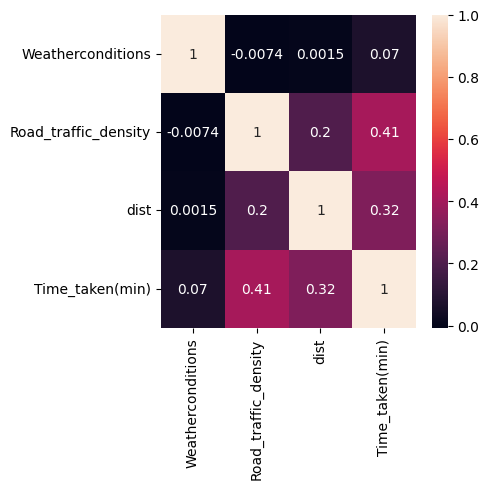

In [28]:
plt.figure(figsize=(5,5))

sns.heatmap(df_filtered[["Weatherconditions", "Road_traffic_density", "dist", "Time_taken(min)"]].corr(), annot=True)

#sns.heatmap(df_filtered.corr(), annot=True)
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

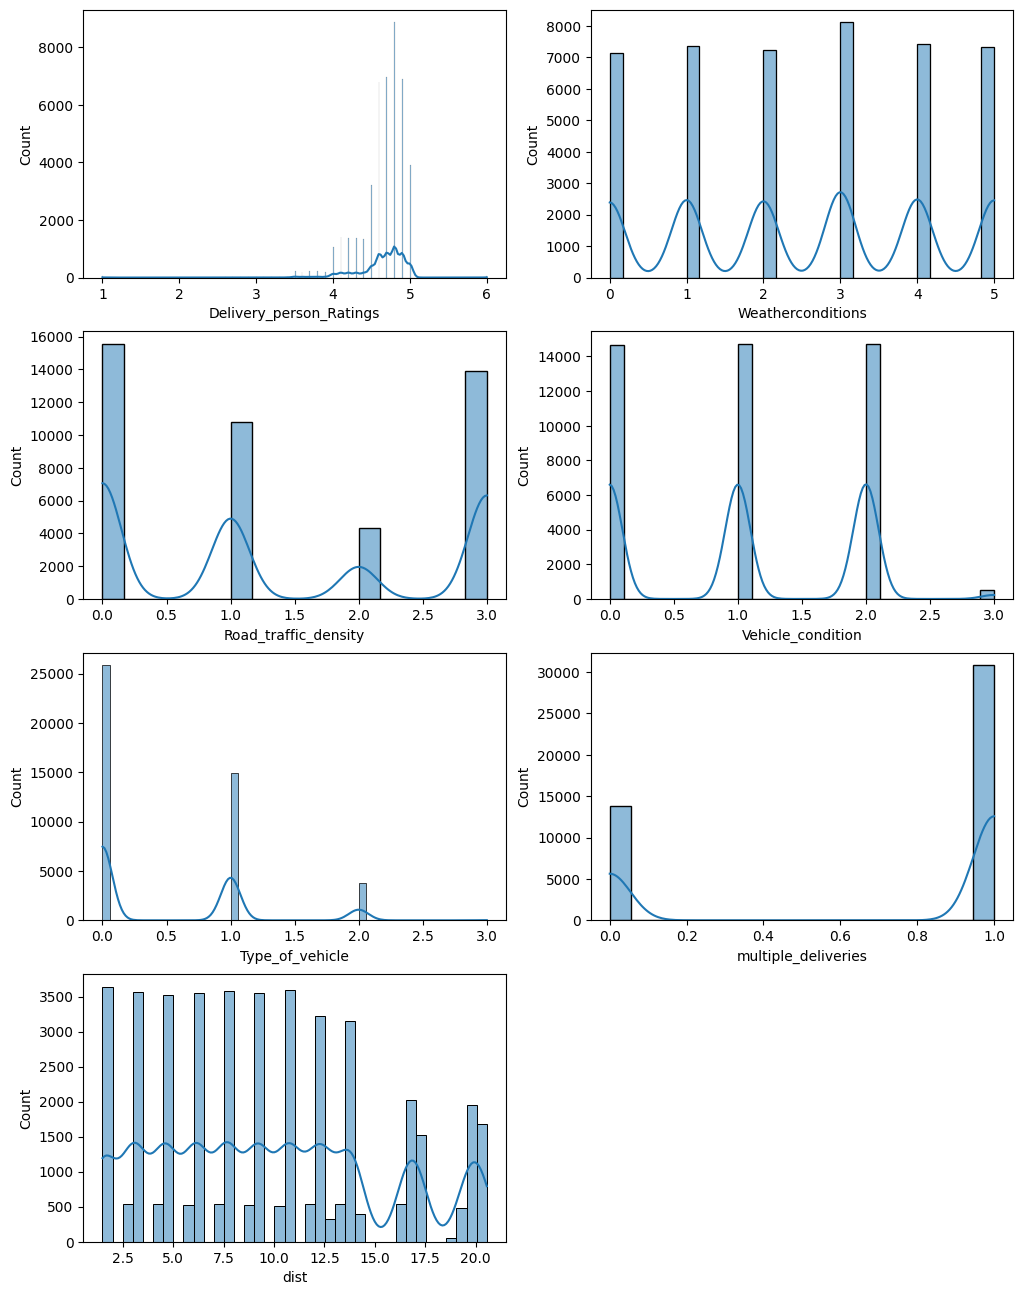

In [29]:
num_list=[i for i in df_filtered.select_dtypes(["int64","float64"])]
cat_list=[i for i in df_filtered.select_dtypes("object")]

k=1
plt.tight_layout()
plt.figure(figsize=(12,16))

for i in df_filtered.loc[:,num_list]:
    plt.subplot(4,2,k)
    sns.histplot(df_filtered[i], kde=True)
    k+=1

Text(0.5, 1.0, 'Histogram of Distance Distribution')

<Figure size 640x480 with 0 Axes>

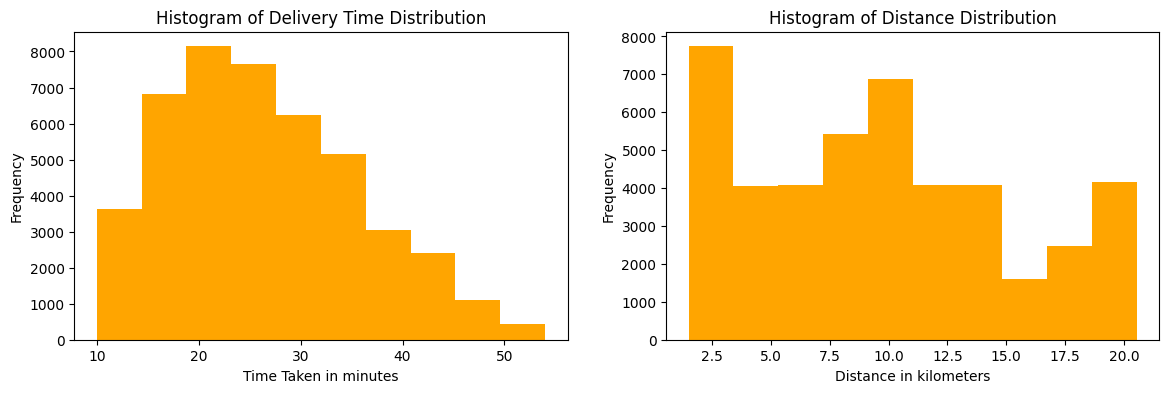

In [30]:
#sns.lineplot(x=df_filtered.dist,y=df_filtered["Time_taken(min)"],data=df_filtered)

plt.tight_layout()
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.hist(df_filtered['Time_taken(min)'],color = 'Orange')
plt.xlabel('Time Taken in minutes')
plt.ylabel('Frequency')
plt.title("Histogram of Delivery Time Distribution")


# fig, ax= plt.subplots()

plt.subplot(1,2,2)
plt.hist(df_filtered['dist'],color = 'Orange')
plt.xlabel('Distance in kilometers')
plt.ylabel('Frequency')
plt.title("Histogram of Distance Distribution")


<Axes: xlabel='Time Taken (min)', ylabel='Distance (km)'>

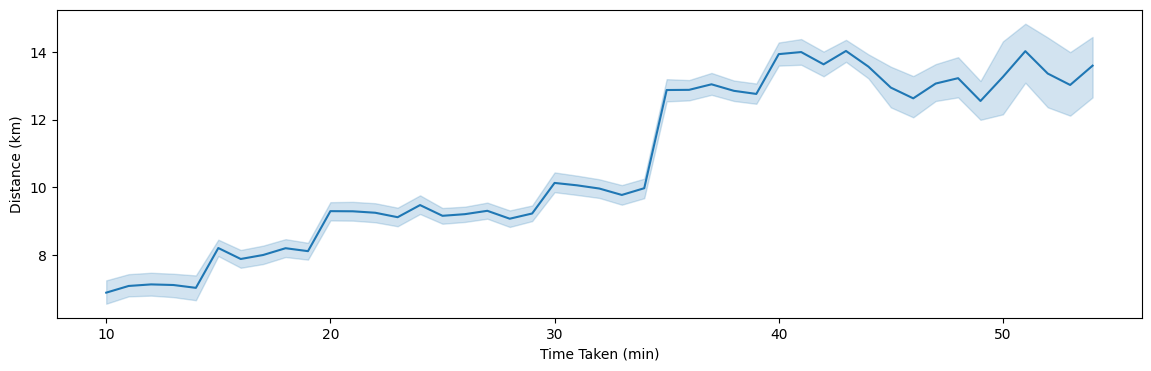

In [31]:
fig,axes = plt.subplots(1,1, figsize=(14,4))
plt.xlabel('Time Taken (min)')
plt.ylabel('Distance (km)')
sns.lineplot(x = df_filtered["Time_taken(min)"], y = df_filtered['dist'], data = df_filtered)

Text(0, 0.5, 'Distance')

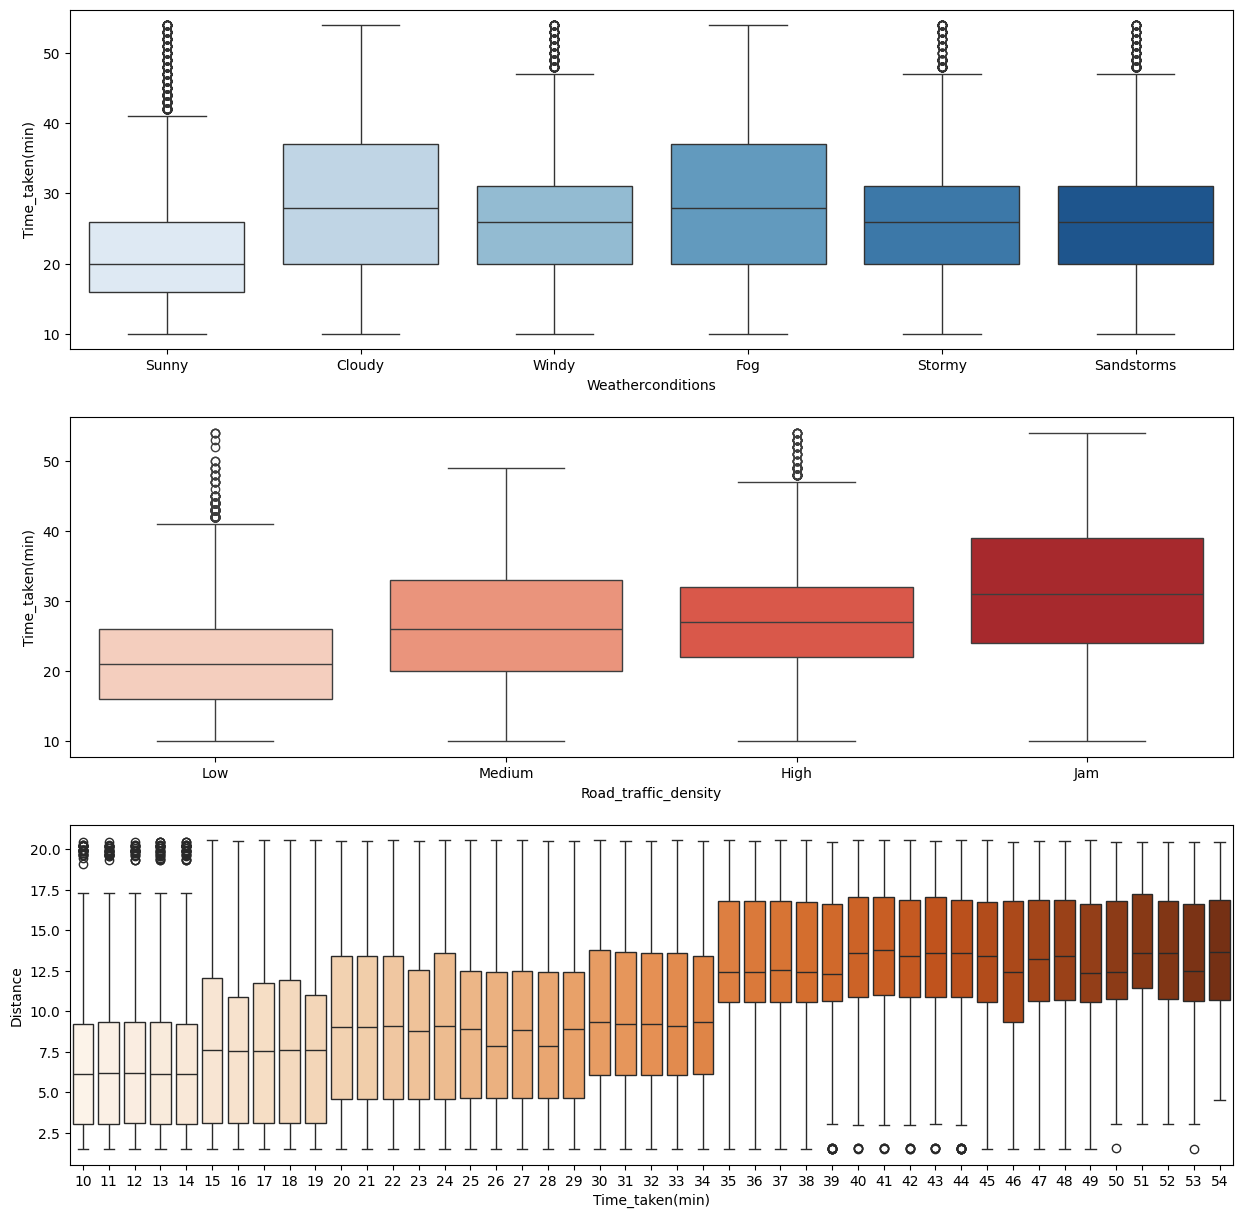

In [32]:
fig,axes = plt.subplots(3,1, figsize=(15,15))

ax = sns.boxplot(data=df_filtered,x = 'Weatherconditions', y ='Time_taken(min)', ax=axes[0], palette="Blues")
ax.set_xticklabels(["Sunny","Cloudy","Windy","Fog","Stormy","Sandstorms"])

ax2 = sns.boxplot(data=df_filtered,x ='Road_traffic_density', y='Time_taken(min)', ax=axes[1], palette="Reds")
ax2.set_xticklabels(["Low", "Medium", "High", "Jam"])

ax3 = sns.boxplot(data=df_filtered,x='Time_taken(min)', y ='dist', ax=axes[2], palette="Oranges")
ax3.set_ylabel("Distance")

In [33]:
df_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
Delivery_person_Ratings,44608.0,4.640623,0.329295,1.000000,4.60000,4.700000,4.800000,6.000000
Weatherconditions,44608.0,2.523045,1.690665,0.000000,1.00000,3.000000,4.000000,5.000000
Road_traffic_density,44608.0,1.372041,1.247299,0.000000,0.00000,1.000000,3.000000,3.000000
Vehicle_condition,44608.0,1.023964,0.839262,0.000000,0.00000,1.000000,2.000000,3.000000
Type_of_vehicle,44608.0,0.507106,0.652913,0.000000,0.00000,0.000000,1.000000,3.000000
multiple_deliveries,44608.0,0.690594,0.462254,0.000000,0.00000,1.000000,1.000000,1.000000
Time_taken(min),44608.0,26.306918,9.379702,10.000000,19.00000,26.000000,32.000000,54.000000
dist,44608.0,9.709858,5.488493,1.492285,4.67415,9.220209,13.631271,20.557591


In [34]:
# print("Training Columns: ", train_df.columns)

In [35]:
X = train_df.drop("Time_taken(min)",axis=1)
Y = train_df["Time_taken(min)"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=101)

In [36]:
def RSE(y_true, y_predicted):
    y_true = np.array(y_true)
    y_predicted = np.array(y_predicted)
    RSS = np.sum(np.square(y_true - y_predicted))

    rse = sqrt(RSS / (len(y_true) - 2))
    return rse

In [37]:
#models=[LinearRegression(),RandomForestRegressor(n_estimators=42,n_jobs=-1),AdaBoostRegressor(),KNeighborsRegressor(),DecisionTreeRegressor(),GradientBoostingRegressor(),XGBRegressor(),LGBMRegressor()]
#model_names=["LinearRegression","RandomForestRegressor","AdaBoostRegressor","KNeighborsRegressor","DecisionTreeRegressor","GradientBoostingRegressor","XGBRegressor","LGBMRegressor"]

models=[LGBMRegressor()]
model_names=["LGBMRegressor"]

MSE=[]
r_2=[]
RSE_ = []
accuracy = []
RMSE = []

for model in range (len(models)):
    model=models[model]
    model.fit(X_train,y_train)
    y_pre=model.predict(X_test)
    MSE.append(round(mean_squared_error(y_true=y_test,y_pred=y_pre),5))
    r_2.append(r2_score(y_true=y_test,y_pred=y_pre))
    RSE_.append(round(RSE(y_test,y_pre),5))
    accuracy.append((model.score(X_test,y_test))*100)
    RMSE.append(sqrt(mean_squared_error(y_true=y_test,y_pred=y_pre)))
d=pd.DataFrame({'Modelling Name':model_names,'MSE':MSE,"R_2":r_2,"RSE":RSE_,"Accuracy":accuracy,"RMSE":RMSE})
d

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 304
[LightGBM] [Info] Number of data points in the train set: 30547, number of used features: 7
[LightGBM] [Info] Start training from score 26.345337


,Modelling Name,MSE,R_2,RSE,Accuracy,RMSE
0,LGBMRegressor,27.03701,0.693628,5.20006,69.362812,5.199713


In [38]:
predictions = models[0].predict(X_test)
# predictions

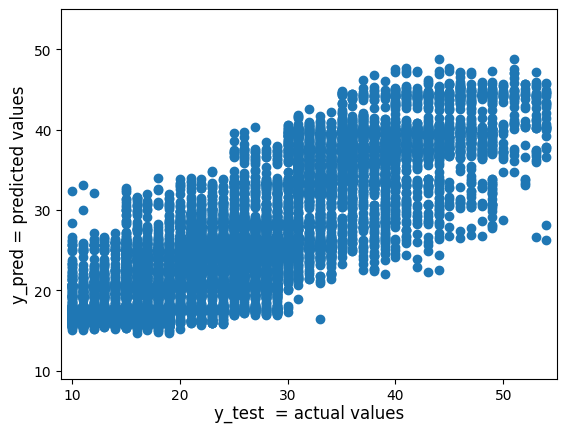

In [39]:
fig, ax = plt.subplots()

x_min, x_max = 9.0, 55.0
y_min, y_max = 9.0, 55.0
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)

ax.set_xlabel('y_test  = actual values', fontsize=12, labelpad=1)
ax.set_ylabel('y_pred = predicted values', fontsize=12)
plt.scatter(y_test, predictions)


<Axes: xlabel='Time_taken(min)', ylabel='Count'>

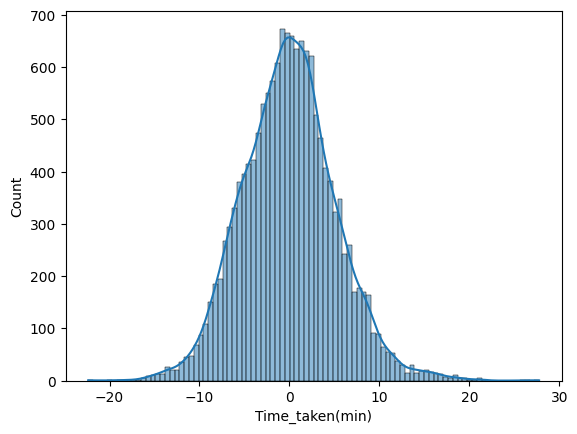

In [40]:
sns.histplot((y_test-predictions), kde=True)

Text(0.5, -0.06, 'Black dots = actual values paired with predicted values. \n     green line = when predicted values equal actual values. \n     blue area = margin of error: 4 (min)')

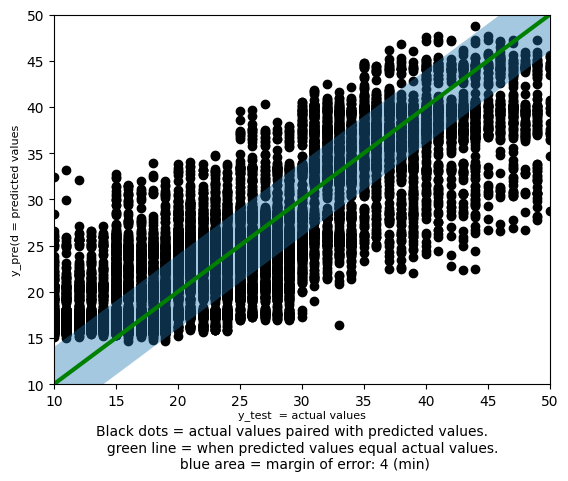

In [41]:
fig, ax = plt.subplots()
x_min, x_max = 10.0, 50.0
y_min, y_max = 10.0, 50.0
m = 4 # margin of error
x = np.linspace(x_min, x_max, 50)
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)

plt.plot(x, x, 'g', linewidth=3)
plt.scatter(y_test, predictions, color="black")
ax.fill_between(x, x - m, x + m, alpha=0.4)

ax.set_xlabel('y_test  = actual values', fontsize=8, labelpad=1)
ax.set_ylabel('y_pre(d = predicted values', fontsize=8)
plt.figtext(0.5, -0.06, "Black dots = actual values paired with predicted values. \n \
    green line = when predicted values equal actual values. \n \
    blue area = margin of error: 4 (min)", wrap=True, horizontalalignment='center' )

In [43]:
width = '120px'

person_rating = widgets.Dropdown(
    options=[('1', 1), ('2', 2), ('3', 3), ('4', 4), ('5', 5), ('6', 6)],
    value=5,
    description='Driver Rating:',
    style= {'description_width': width}
)
weather_cond = widgets.Dropdown(
    options=[('Sunny', 0), ('Cloudy', 1), ('Windy', 2), ('Fog', 3), ('Stormy', 4), ('Sandstorm', 5)],
    value=0,
    description='Weather:',
    style= {'description_width': width}
)
mult_delivery = widgets.Dropdown(
    options=[('No', 0), ('Yes', 1)],
    value=0,
    description='Multiple Deliveries:',
    style= {'description_width': width}
)
traffic = widgets.FloatSlider(
    description='Traffic Density:', 
    min=0, 
    max=3, 
    step=1, 
    style= {'description_width': width}
)
distance = widgets.FloatSlider(
    description='Distance (km):', 
    min=1.0, 
    max=20.0, 
    step=0.1, 
    style= {'description_width': width}
)

# Buttons
button_predict = widgets.Button(description='Predict Delivery Time')
button_clear = widgets.Button(description='Clear Output')
button_ouput = widgets.Output()

# Buttona ctions
def on_click_predict(b):
    data = {
        "Delivery_person_Ratings": [person_rating.value],
        "Weatherconditions": [weather_cond.value],
        "Road_traffic_density": [traffic.value],
        "Vehicle_condition": [0],
        "Type_of_vehicle": [0],
        "multiple_deliveries": [mult_delivery.value],
        "dist": [distance.value]
    }
    udf = pd.DataFrame(data)
    pred = models[0].predict(udf)
    with button_ouput:
        print('Predicted Delivery Time (minutes) = ', str(pred))

def on_click_clear(b):
    button_ouput.clear_output()

button_predict.on_click(on_click_predict)
button_clear.on_click(on_click_clear)

# Displays text boxes and buttons inside a VBox
print('\033[1m' + 'Enter parameters and make a prediction:' + '\033[0m')
widgets.VBox([
    person_rating,
    weather_cond,
    mult_delivery,
    traffic,
    distance,
    button_predict,
    button_clear,
    button_ouput]
)


Enter parameters and make a prediction:
